In [14]:
import numpy as np
from scipy import fftpack
import tensorly as tl
import time
from tensorly.decomposition import tucker
import tensorsketch
from tensorsketch import util
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle 
import simulation
plt.style.use('seaborn-paper')
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')


In [15]:
def sim_name(gen_type,r,noise_level,dim, rm_typ): 
    """
    Obtain the file name to use for a given simulation setting
    """
    if noise_level == 0: 
        noise = "no"
    else: 
        noise = str(int(np.log10(noise_level)))
    return "data/typ"+gen_type+"_r"+str(r)+"_noise"+noise+"_dim"+str(dim)+ "_" + rm_typ

In [16]:
def run_nssim(gen_type,r,noise_level, ns = np.arange(100,101,100), dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "g"): 
    """
    Simulate multiple datasets with different n for multiple runs. For each run, perform the HOOI, 
    two pass sketching, and one pass sketching 
    
    :param gen_type: Type of random matrix used in sketching, including 'u' uniform, 'g' gaussian, 'sp'
        sparse radamacer. 
    :param r: tucker rank of the simulated tensor 
    :param noise_level: noise level. It inverse equals to the signal-to-noise ratio.  
    :param ns: array of different n, the side length of the square tensor 
    :param dim: the dimension of the square tensor 
    :param sim_runs: num of simulated runs in each setting 
    :param random_seed: random seed for generating the random matrix  
    """
    sim_list = []
    for id, n in enumerate(ns): 
        if gen_type in ['id','lk']: 
            ks =np.arange(r, int(n/2),int(n/20)) 
        elif gen_type in ['spd','fpd']: 
            ks = np.arange(r,int(n/5),int(n/50))
        else: 
            ks = np.arange(r,int(n/10),int(n/100))
        hooi_rerr = np.zeros((sim_runs, len(ks)))
        two_pass_rerr = np.zeros((sim_runs,len(ks)))
        one_pass_rerr = np.zeros((sim_runs,len(ks)))
        for i in range(sim_runs): 
            for idx, k in enumerate(ks): 
                simu = simulation.Simulation(n, r, k, 2*k+1, dim, tensorsketch.util.RandomInfoBucket(random_seed=random_seed), gen_type, noise_level,rm_typ)
                rerr_hooi, rerr_twopass, rerr_onepass = simu.run_sim()
                hooi_rerr[i,idx] = rerr_hooi
                two_pass_rerr[i,idx] = rerr_twopass
                one_pass_rerr[i,idx] = rerr_onepass
        sim_list.append([two_pass_rerr,one_pass_rerr,hooi_rerr])
    pickle.dump( sim_list, open(sim_name(gen_type,r,noise_level,dim, rm_typ) +".pickle", "wb" ) )
    return sim_list

In [17]:
def plot_nssim(gen_type,r,noise_level,name,n, ns = [200,400,600], dim = 3, sim_runs = 1,random_seed = 1,fontsize = 18, rm_typ = "g"): 
    '''
    Plot the simulation results given in run_nssim
    '''
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    sim_list = pickle.load( open( sim_name(gen_type,r,noise_level,dim, rm_typ)+".pickle", "rb" ) ) 
    plot_id = ns.index(n)
    if gen_type in ['id','lk']: 
        ks =np.arange(r, int(n/2),int(n/20)) 
    elif gen_type in ['spd','fpd']: 
        ks = np.arange(r,int(n/5),int(n/50))
    else: 
        ks = np.arange(r,int(n/10),int(n/100))
    plt.figure(figsize=(6,5))
    plt.plot(ks/n,np.mean(sim_list[plot_id][0],0), label = 'Two Pass', markersize = 10,linestyle = '--',marker = 'X')
    plt.plot(ks/n,np.mean(sim_list[plot_id][1],0), label = 'One Pass', markersize = 10, marker = 's',markeredgewidth=1,markeredgecolor='orange', markerfacecolor='None') 
    plt.plot(ks/n,np.mean(sim_list[plot_id][2],0), label = 'HOOI', markersize = 10, linestyle = ':', marker = 'o', markeredgewidth=1,markeredgecolor='g', markerfacecolor='None') 
    plt.title("I = %s"%(n))
    plt.legend(loc = 'best')
    plt.xlabel('Compression Factor: $\delta_1$ = k/I')
    plt.ylabel('Relative Error')
    plt.yscale('log')
    plt.minorticks_off()
    alldata = np.concatenate((np.mean(sim_list[plot_id][0],0),np.mean(sim_list[plot_id][1],0),np.mean(sim_list[plot_id][2],0)))
    ymin = min(alldata)
    ymax = max(alldata)  
    def round_to_n(x,n): 
        return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
    plt.yticks(ticks)
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig('plots/'+name)
    plt.show()

In [5]:
run_nssim('sed',5,0.01,np.arange(200,601,200),rm_typ = "ssrft") 
run_nssim('fed',5,0.01,np.arange(200,601,200),rm_typ = "ssrft") 
run_nssim('spd',5,0.01,np.arange(200,601,200),rm_typ = "ssrft") 
run_nssim('fpd',5,0.01,np.arange(200,601,200),rm_typ = "ssrft") 
run_nssim('id',5,0.01,np.arange(200,601,200),rm_typ = "ssrft") 
run_nssim('id',5,0.1,np.arange(200,601,200),rm_typ = "ssrft") 
run_nssim('id',5,1,np.arange(200,601,200),rm_typ = "ssrft") 
run_nssim('id',1,0.01,np.arange(200,601,200),rm_typ = "ssrft") 
run_nssim('lk',5,0.01,np.arange(200,601,200),rm_typ = "ssrft") 
run_nssim('lk',5,0.1,np.arange(200,601,200),rm_typ = "ssrft") 
run_nssim('lk',5,1,np.arange(200,601,200),rm_typ = "ssrft") 

Using numpy backend.
Using numpy backend.
Using numpy backend.


KeyboardInterrupt: 

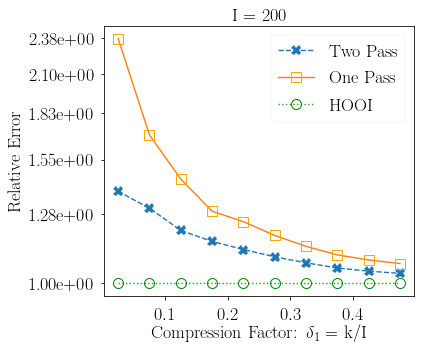

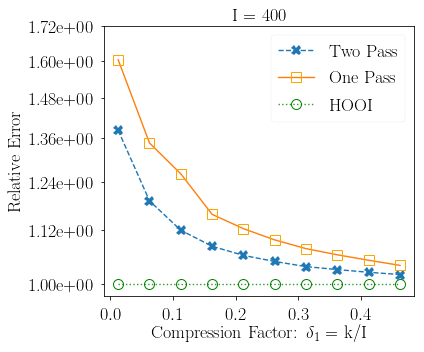

KeyboardInterrupt: 

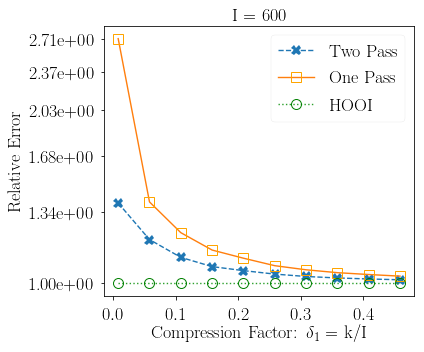

In [12]:
plot_nssim('id',5,1,"id_hnoise_n200_ssrft.pdf",200,rm_typ = "ssrft")
plot_nssim('id',5,1,"id_hnoise_n400_ssrft.pdf",400,rm_typ = "ssrft")
plot_nssim('id',5,1,"id_hnoise_n600_ssrft.pdf",600,rm_typ = "ssrft")
plot_nssim('id',5,0.1,"id_mnoise_n200_ssrft.pdf",200,rm_typ = "ssrft")
plot_nssim('id',5,0.1,"id_mnoise_n400_ssrft.pdf",400,rm_typ = "ssrft")
plot_nssim('id',5,0.1,"id_mnoise_n600_ssrft.pdf",600,rm_typ = "ssrft")
plot_nssim('id',5,0.01,"id_lnoise_n200_ssrft.pdf",200,rm_typ = "ssrft")
plot_nssim('id',5,0.01,"id_lnoise_n400_ssrft.pdf",400,rm_typ = "ssrft")
plot_nssim('id',5,0.01,"id_lnoise_n600_ssrft.pdf",600,rm_typ = "ssrft")
plot_nssim('lk',5,1,"lk_hnoise_n200_ssrft.pdf",200,rm_typ = "ssrft")
plot_nssim('lk',5,1,"lk_hnoise_n400_ssrft.pdf",400,rm_typ = "ssrft")
plot_nssim('lk',5,1,"lk_hnoise_n600_ssrft.pdf",600,rm_typ = "ssrft")
plot_nssim('lk',5,0.1,"lk_mnoise_n200_ssrft.pdf",200,rm_typ = "ssrft")
plot_nssim('lk',5,0.1,"lk_mnoise_n400_ssrft.pdf",400,rm_typ = "ssrft")
plot_nssim('lk',5,0.1,"lk_mnoise_n600_ssrft.pdf",600,rm_typ = "ssrft")
plot_nssim('lk',5,0.01,"lk_lnoise_n200_ssrft.pdf",200,rm_typ = "ssrft")
plot_nssim('lk',5,0.01,"lk_lnoise_n400_ssrft.pdf",400,rm_typ = "ssrft")
plot_nssim('lk',5,0.01,"lk_lnoise_n600_ssrft.pdf",600,rm_typ = "ssrft")
plot_nssim('id',5,0.01,"id_rk1_n200_ssrft.pdf",200,rm_typ = "ssrft")
plot_nssim('id',5,0.01,"id_rk1_n400_ssrft.pdf",400,rm_typ = "ssrft")
plot_nssim('id',5,0.01,"id_rk1_n600_ssrft.pdf",600,rm_typ = "ssrft")
plot_nssim('spd',5,0.01,"spd_n200_ssrft.pdf",200,rm_typ = "ssrft")
plot_nssim('spd',5,0.01,"spd_n400_ssrft.pdf",400,rm_typ = "ssrft")
plot_nssim('spd',5,0.01,"spd_n600_ssrft.pdf",600,rm_typ = "ssrft")
plot_nssim('fpd',5,0.01,"fpd_n200_ssrft.pdf",200,rm_typ = "ssrft")
plot_nssim('fpd',5,0.01,"fpd_n400_ssrft.pdf",400,rm_typ = "ssrft")
plot_nssim('fpd',5,0.01,"fpd_n600_ssrft.pdf",600,rm_typ = "ssrft")
plot_nssim('sed',5,0.01,"sed_n200_ssrft.pdf",200,rm_typ = "ssrft")
plot_nssim('sed',5,0.01,"sed_n400_ssrft.pdf",400,rm_typ = "ssrft")
plot_nssim('sed',5,0.01,"sed_n600_ssrft.pdf",600,rm_typ = "ssrft")
plot_nssim('fed',5,0.01,"fed_n200_ssrft.pdf",200,rm_typ = "ssrft")
plot_nssim('fed',5,0.01,"fed_n400_ssrft.pdf",400,rm_typ = "ssrft")
plot_nssim('fed',5,0.01,"fed_n600_ssrft.pdf",600,rm_typ = "ssrft")

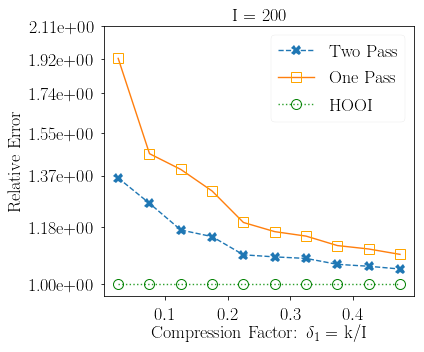

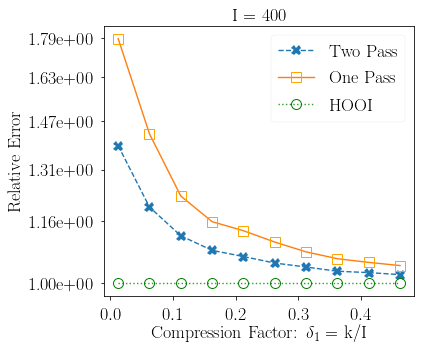

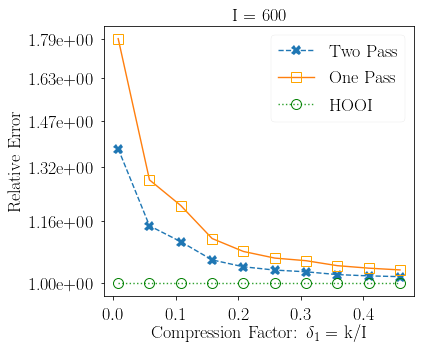

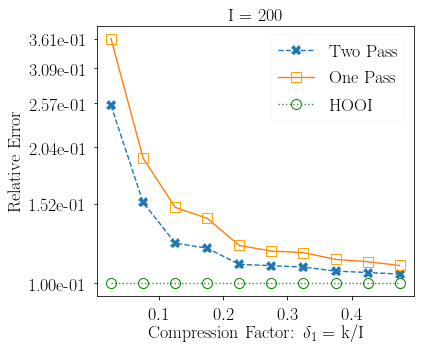

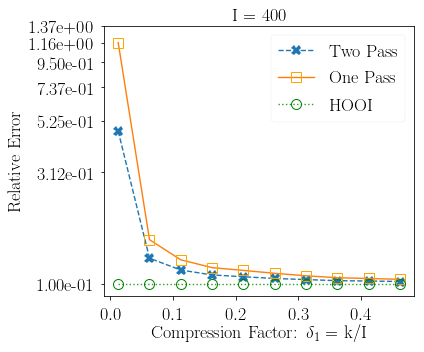

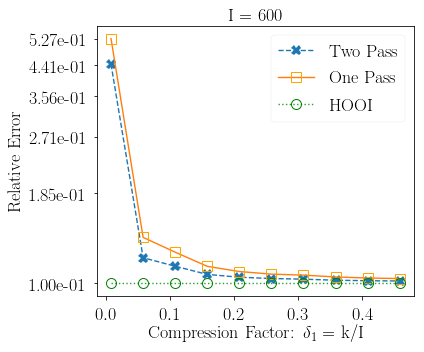

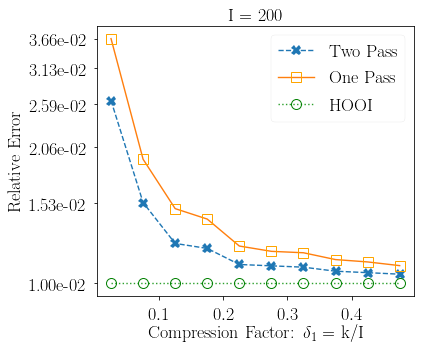

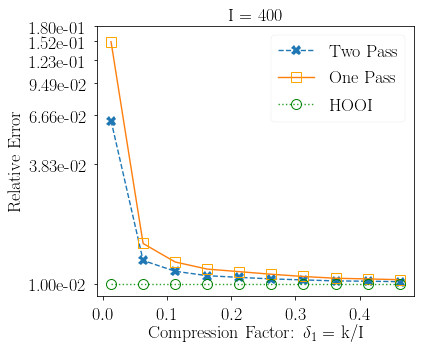

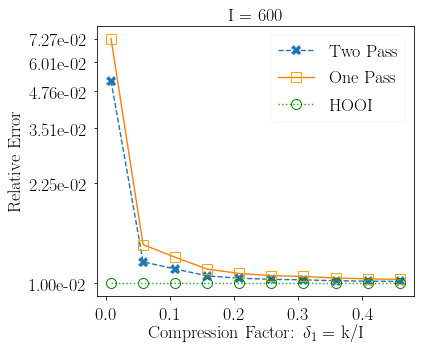

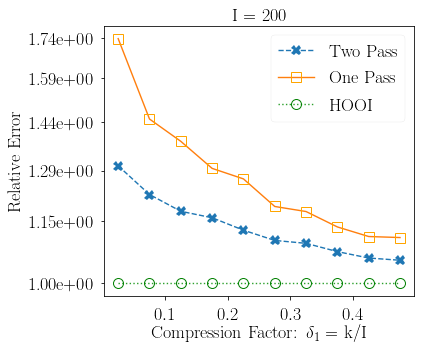

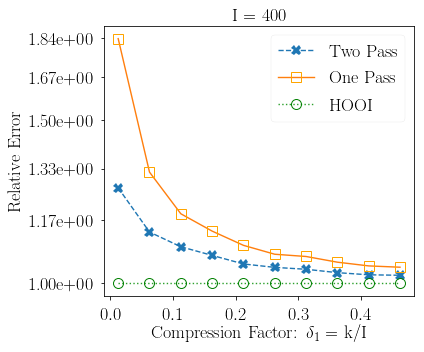

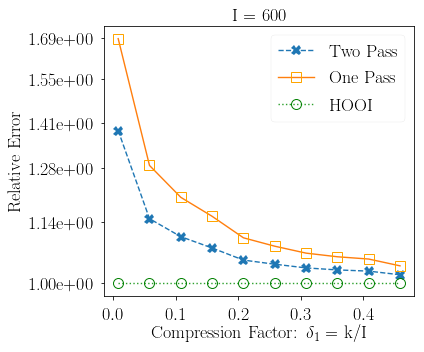

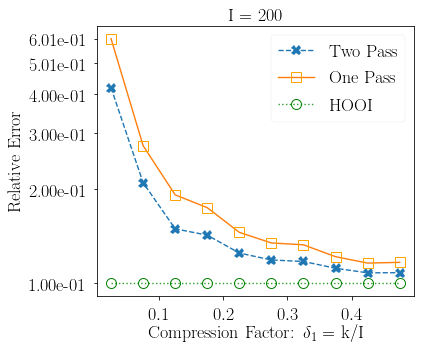

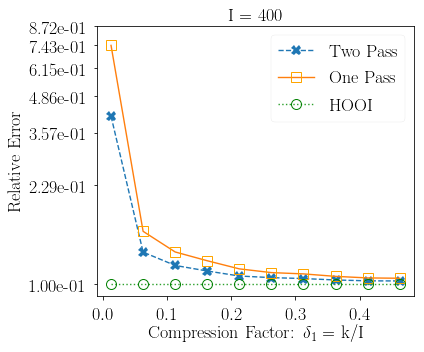

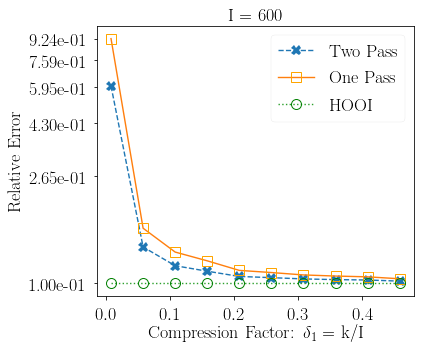

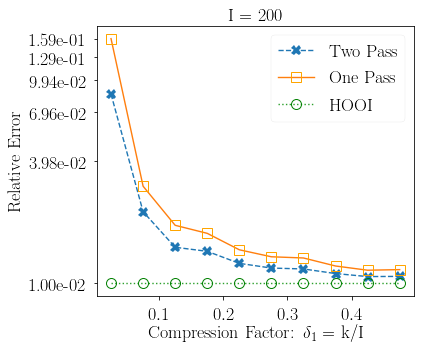

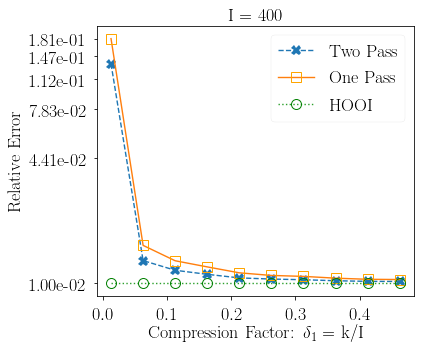

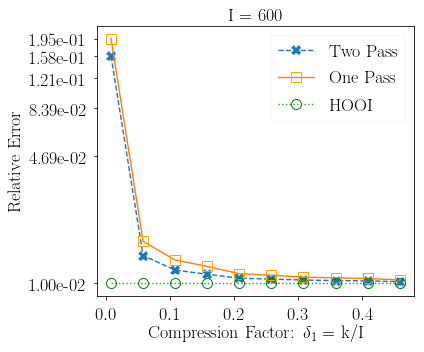

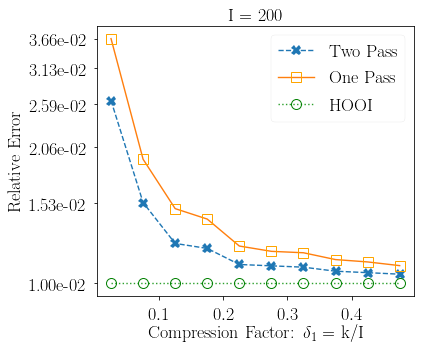

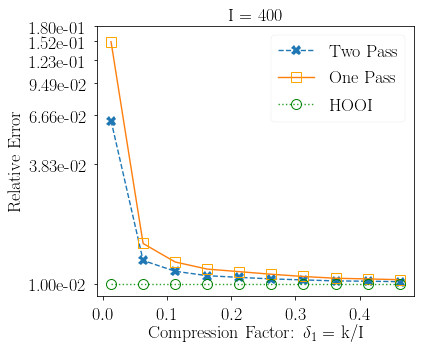

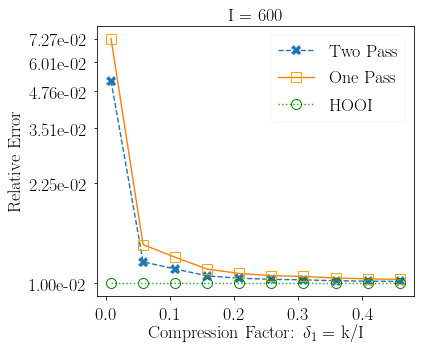

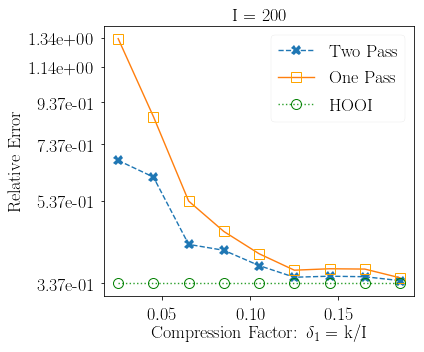

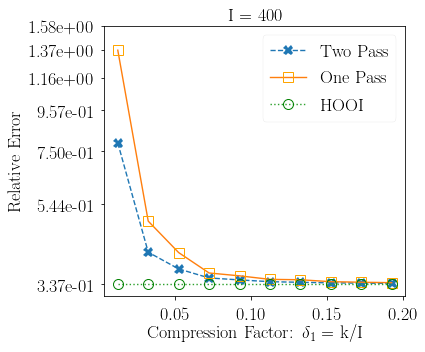

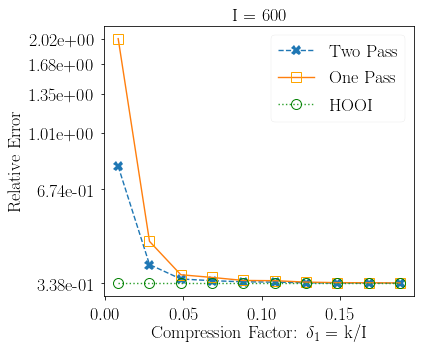

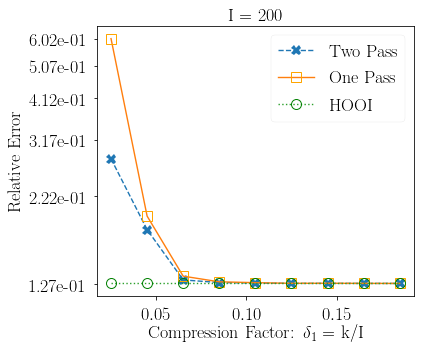

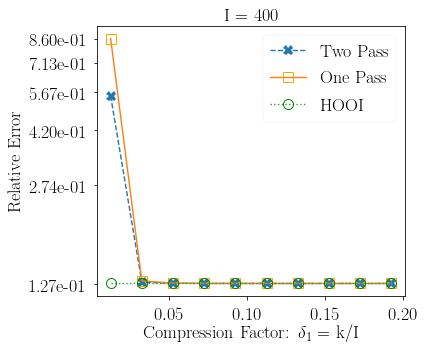

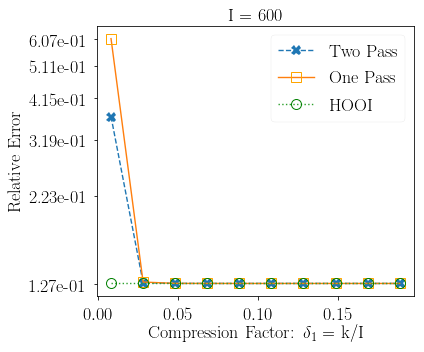

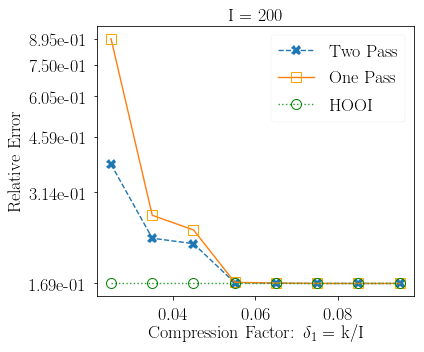

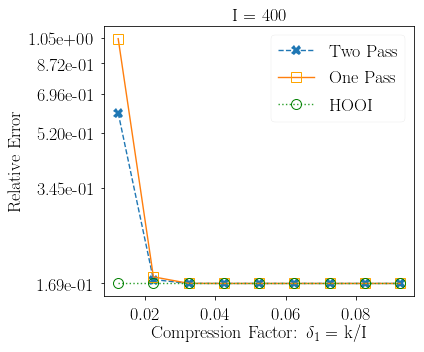

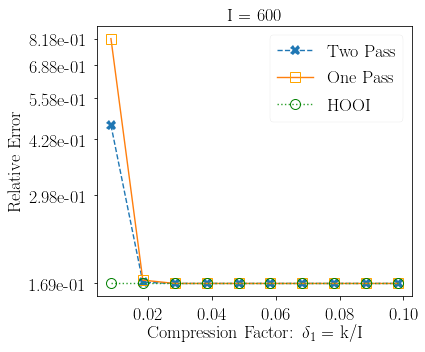

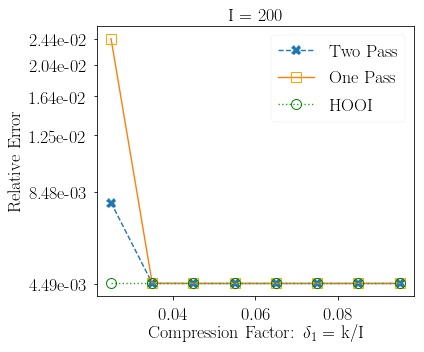

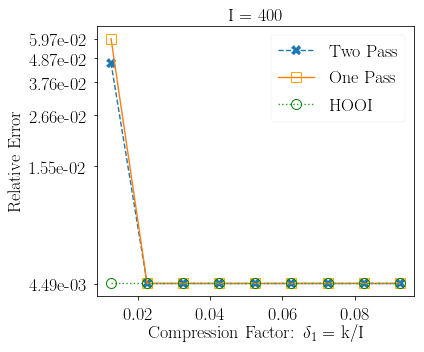

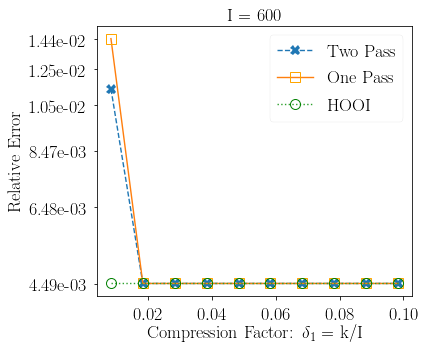

In [13]:
plot_nssim('id',5,1,"id_hnoise_n200_gprod.pdf",200,rm_typ = "gprod")
plot_nssim('id',5,1,"id_hnoise_n400_gprod.pdf",400,rm_typ = "gprod")
plot_nssim('id',5,1,"id_hnoise_n600_gprod.pdf",600,rm_typ = "gprod")
plot_nssim('id',5,0.1,"id_mnoise_n200_gprod.pdf",200,rm_typ = "gprod")
plot_nssim('id',5,0.1,"id_mnoise_n400_gprod.pdf",400,rm_typ = "gprod")
plot_nssim('id',5,0.1,"id_mnoise_n600_gprod.pdf",600,rm_typ = "gprod")
plot_nssim('id',5,0.01,"id_lnoise_n200_gprod.pdf",200,rm_typ = "gprod")
plot_nssim('id',5,0.01,"id_lnoise_n400_gprod.pdf",400,rm_typ = "gprod")
plot_nssim('id',5,0.01,"id_lnoise_n600_gprod.pdf",600,rm_typ = "gprod")
plot_nssim('lk',5,1,"lk_hnoise_n200_gprod.pdf",200,rm_typ = "gprod")
plot_nssim('lk',5,1,"lk_hnoise_n400_gprod.pdf",400,rm_typ = "gprod")
plot_nssim('lk',5,1,"lk_hnoise_n600_gprod.pdf",600,rm_typ = "gprod")
plot_nssim('lk',5,0.1,"lk_mnoise_n200_gprod.pdf",200,rm_typ = "gprod")
plot_nssim('lk',5,0.1,"lk_mnoise_n400_gprod.pdf",400,rm_typ = "gprod")
plot_nssim('lk',5,0.1,"lk_mnoise_n600_gprod.pdf",600,rm_typ = "gprod")
plot_nssim('lk',5,0.01,"lk_lnoise_n200_gprod.pdf",200,rm_typ = "gprod")
plot_nssim('lk',5,0.01,"lk_lnoise_n400_gprod.pdf",400,rm_typ = "gprod")
plot_nssim('lk',5,0.01,"lk_lnoise_n600_gprod.pdf",600,rm_typ = "gprod")
plot_nssim('id',5,0.01,"id_rk1_n200_gprod.pdf",200,rm_typ = "gprod")
plot_nssim('id',5,0.01,"id_rk1_n400_gprod.pdf",400,rm_typ = "gprod")
plot_nssim('id',5,0.01,"id_rk1_n600_gprod.pdf",600,rm_typ = "gprod")
plot_nssim('spd',5,0.01,"spd_n200_gprod.pdf",200,rm_typ = "gprod")
plot_nssim('spd',5,0.01,"spd_n400_gprod.pdf",400,rm_typ = "gprod")
plot_nssim('spd',5,0.01,"spd_n600_gprod.pdf",600,rm_typ = "gprod")
plot_nssim('fpd',5,0.01,"fpd_n200_gprod.pdf",200,rm_typ = "gprod")
plot_nssim('fpd',5,0.01,"fpd_n400_gprod.pdf",400,rm_typ = "gprod")
plot_nssim('fpd',5,0.01,"fpd_n600_gprod.pdf",600,rm_typ = "gprod")
plot_nssim('sed',5,0.01,"sed_n200_gprod.pdf",200,rm_typ = "gprod")
plot_nssim('sed',5,0.01,"sed_n400_gprod.pdf",400,rm_typ = "gprod")
plot_nssim('sed',5,0.01,"sed_n600_gprod.pdf",600,rm_typ = "gprod")
plot_nssim('fed',5,0.01,"fed_n200_gprod.pdf",200,rm_typ = "gprod")
plot_nssim('fed',5,0.01,"fed_n400_gprod.pdf",400,rm_typ = "gprod")
plot_nssim('fed',5,0.01,"fed_n600_gprod.pdf",600,rm_typ = "gprod")

In [40]:
def plot_nssimlog(gen_type,r,noise_level,name,n, ns = [200,400,600], dim = 3, sim_runs = 1,random_seed = 1,fontsize = 18, rm_typ = 'g'): 
    '''
    Plot the simulation results from run_nssim in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    sim_list = pickle.load( open( sim_name(gen_type,r,noise_level,dim, rm_typ)+".pickle", "rb" ) ) 
    plot_id = ns.index(n)
    if gen_type in ['id','lk']: 
        ks =np.arange(r, int(n/2),int(n/20)) 
    elif gen_type in ['spd','fpd']: 
        ks = np.arange(r,int(n/5),int(n/50))
    else: 
        ks = np.arange(r,int(n/10),int(n/100))
    plt.figure(figsize=(6,5))
    two_pass_result = np.mean(sim_list[plot_id][0],0)  
    one_pass_result = np.mean(sim_list[plot_id][1],0)
    hosvd_result = np.mean(sim_list[plot_id][2],0) 
    two_pass_logratio = [np.log(two_pass_result[i]/hosvd_result[i]) for i in range(len(hosvd_result))]
    one_pass_logratio = [np.log(one_pass_result[i]/hosvd_result[i]) for i in range(len(hosvd_result))]
    plt.plot(ks/n, two_pass_logratio, label = 'Two Pass', markersize = 10, linestyle = '--',marker = 'X')
    plt.plot(ks/n, one_pass_logratio, label = 'One Pass', markersize = 10, marker = 's',markeredgewidth=1,markeredgecolor='orange', markerfacecolor='None') 
    plt.title("I = %s"%(n))
    #plt.title("$\gamma$ = %s"%(noise_level))
    plt.legend(loc = 'best')
    plt.xlabel('Compression Factor: $\delta_1$ = k/I')
    plt.ylabel('log(Relative Error)')
    plt.minorticks_off()
    alldata = np.concatenate([two_pass_logratio,one_pass_logratio])
    ymin = 0
    ymax = max(alldata)  
    def round_to_n(x,n): 
        if x == 0: 
            return 0
        else:
            return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
    plt.yticks(ticks)
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig('plots/'+name)
    plt.show()

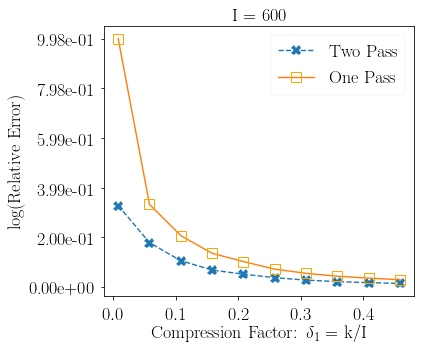

In [42]:
plot_nssimlog('id',5,1,"multi_id_hnoise_n600log_paper_ssrft.pdf",600, rm_typ = 'ssrft')

In [85]:
def multiplot_nssimlog(rm_typs,gen_type,r,noise_level,name,n, ns = [200,400,600], dim = 3, sim_runs = 1,random_seed = 1,fontsize = 18): 
    '''
    Plot the simulation results from run_nssim in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    sim_list = []
    plt.figure(figsize=(6,5))
    ymaxs = []
    for i,rm_typ in enumerate(rm_typs): 
        sim_list.append(pickle.load( open(sim_name(gen_type,r,noise_level,dim,rm_typ)+".pickle", "rb" ) ))
        plot_id = ns.index(n)
        if gen_type in ['id','lk']: 
            ks =np.arange(r, int(n/2),int(n/20)) 
        elif gen_type in ['spd','fpd']: 
            ks = np.arange(r,int(n/5),int(n/50))
        else: 
            ks = np.arange(r,int(n/10),int(n/100))
        two_pass_result = np.mean(sim_list[i][plot_id][0],0)  
        one_pass_result = np.mean(sim_list[i][plot_id][1],0)
        hosvd_result = np.mean(sim_list[i][plot_id][2],0) 
        two_pass_logratio = [np.log(two_pass_result[i]/hosvd_result[i]) for i in range(len(hosvd_result))]
        one_pass_logratio = [np.log(one_pass_result[i]/hosvd_result[i]) for i in range(len(hosvd_result))]
        plt.plot(ks/n, two_pass_logratio, label = rm_typ+' Two Pass', markersize = 10, linestyle = '--',marker = 'X')
        plt.plot(ks/n, one_pass_logratio, label = rm_typ+' One Pass', markersize = 10, marker = 's',markeredgewidth=1, markerfacecolor='None') 
        plt.title("I = %s"%(n))
        alldata = np.concatenate([two_pass_logratio,one_pass_logratio])
        ymaxs.append(max(alldata))
    #plt.title("$\gamma$ = %s"%(noise_level))
    plt.legend(loc = 'best')
    plt.xlabel('Compression Factor: $\delta_1$ = k/I')
    plt.ylabel('log(Relative Error)')
    plt.minorticks_off()
    alldata = np.concatenate([two_pass_logratio,one_pass_logratio])
    ymin = 0
    ymax = max(ymaxs)  
    def round_to_n(x,n): 
        if x == 0: 
            return 0
        else:
            return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
    plt.yticks(ticks)
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig('plots/'+name)
    plt.show()

0
g
1
u
2
ssrft
3
gprod


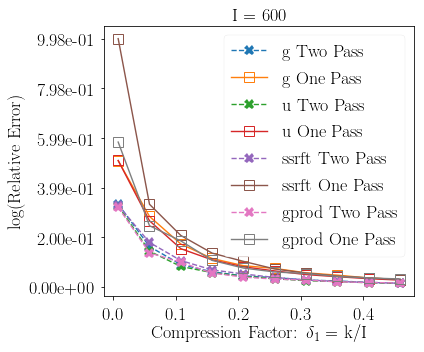

In [77]:
multiplot_nssimlog(['g','u','ssrft', 'gprod'], 'id',5,1,"multi_id_hnoise_n600log_paper.pdf",600)


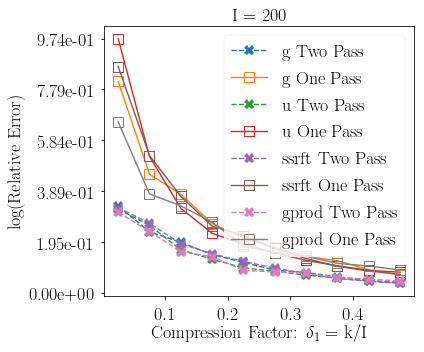

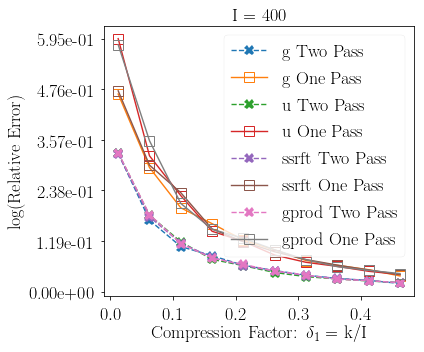

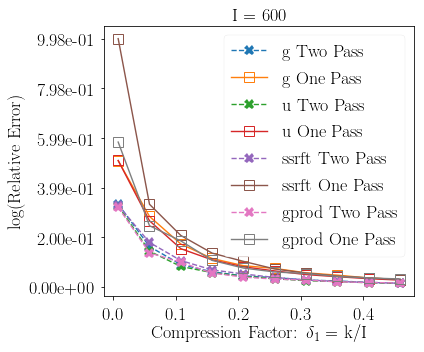

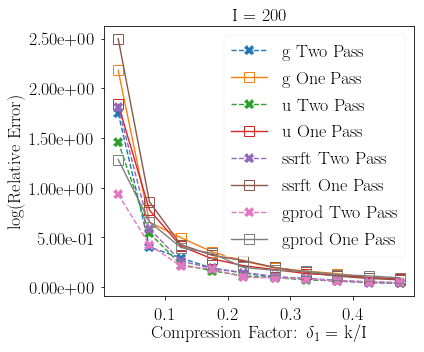

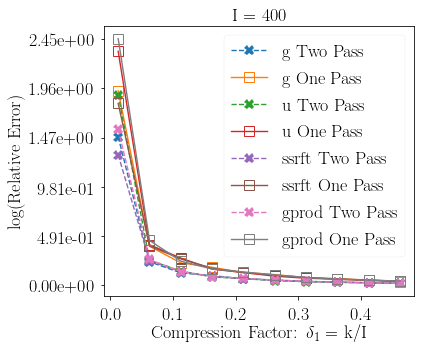

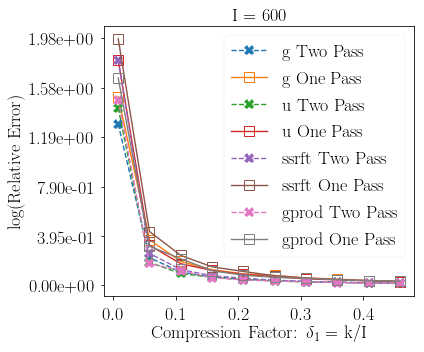

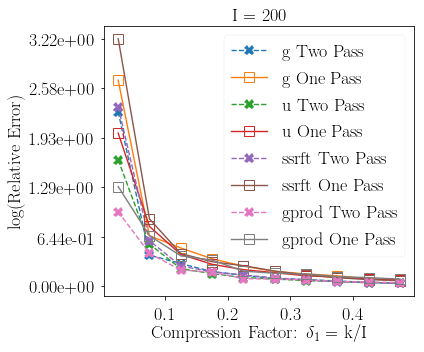

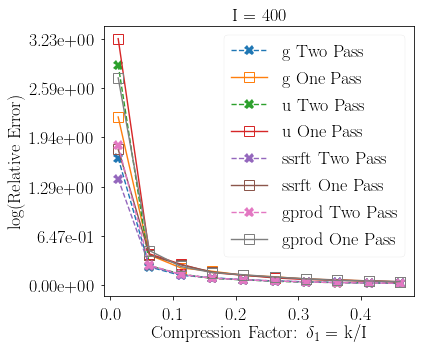

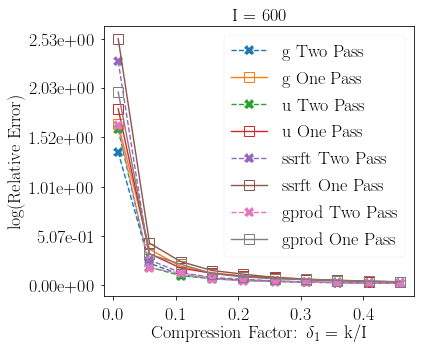

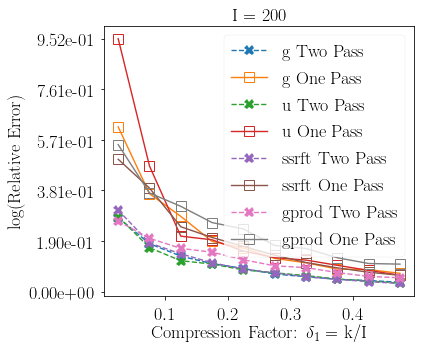

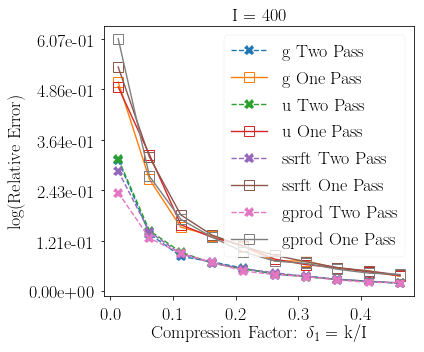

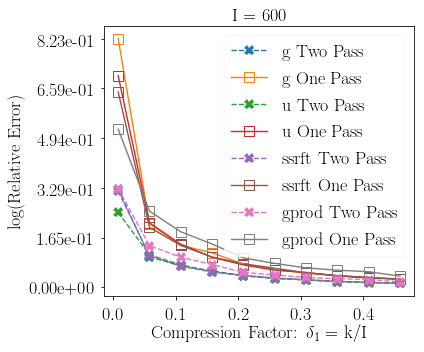

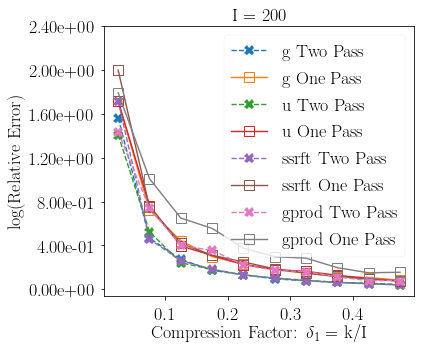

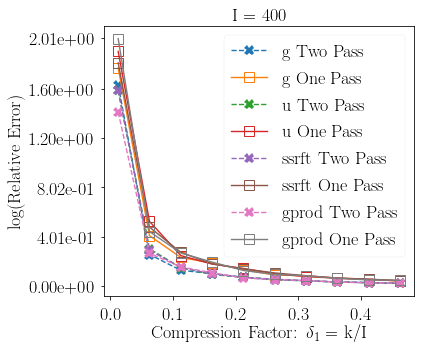

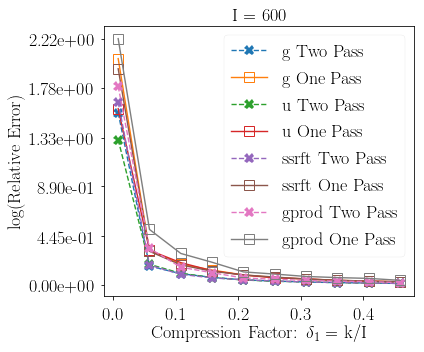

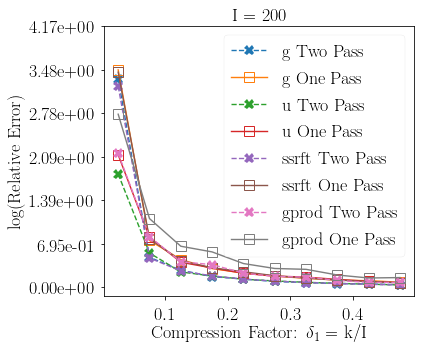

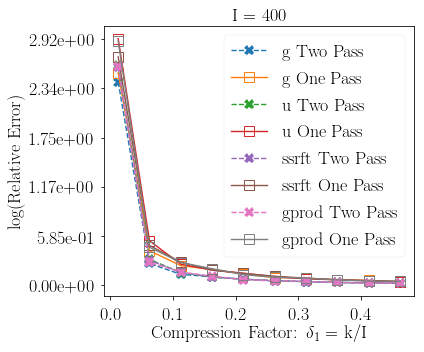

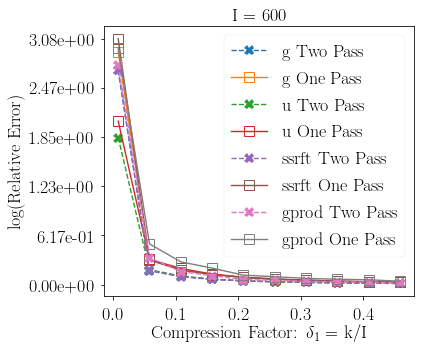

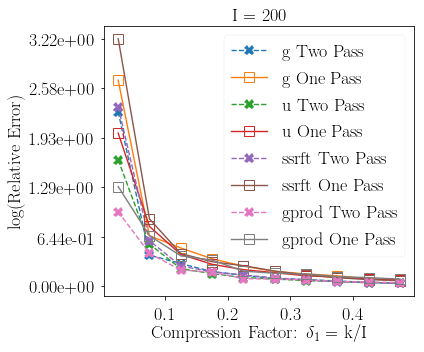

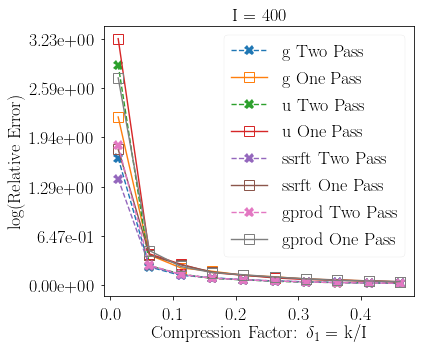

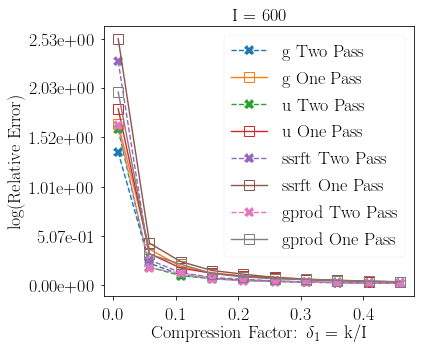

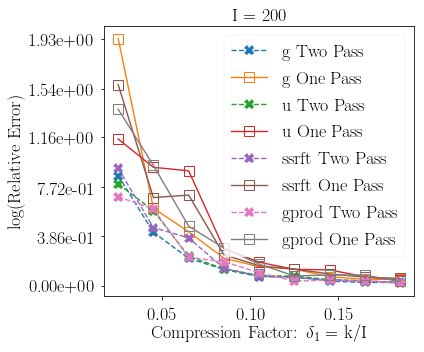

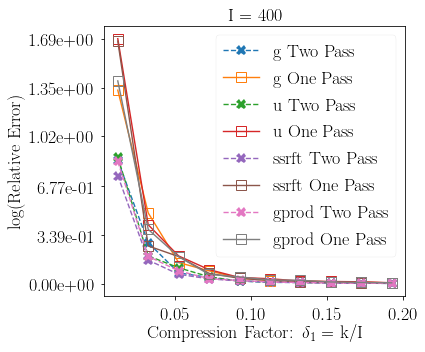

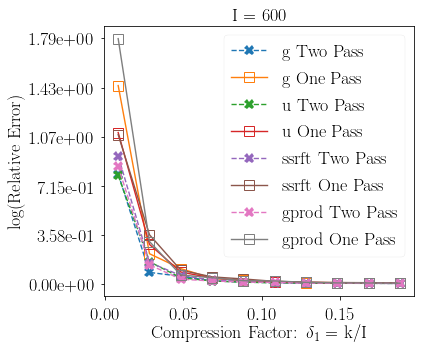

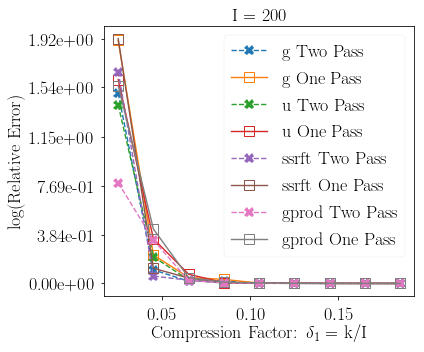

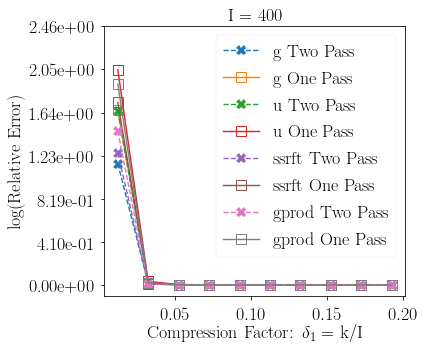

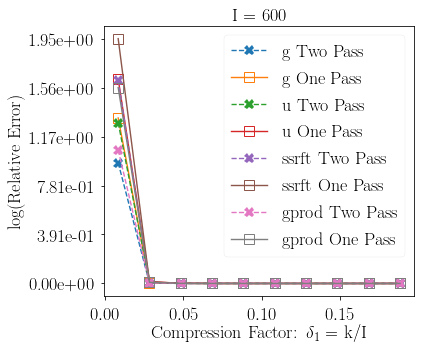

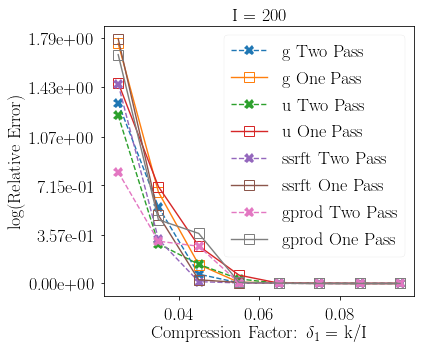

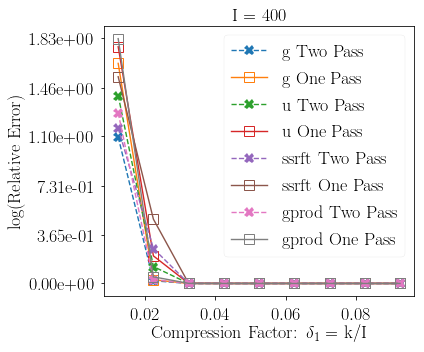

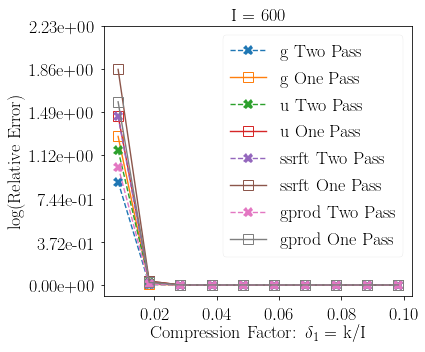

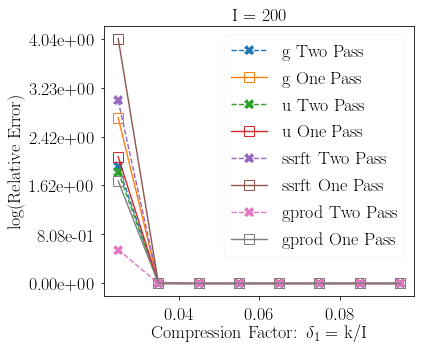

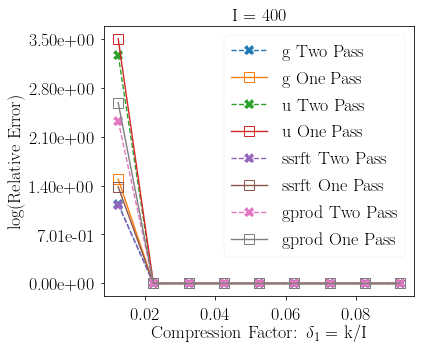

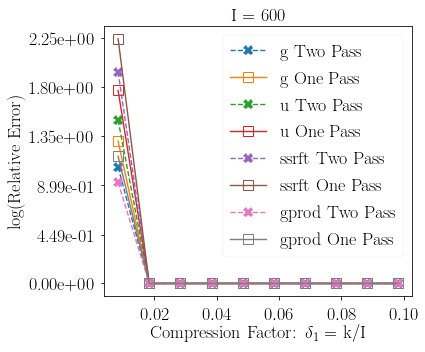

In [86]:
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'id',5,1,"multi_id_hnoise_n200log.pdf",200)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'id',5,1,"multi_id_hnoise_n400log.pdf",400)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'id',5,1,"multi_id_hnoise_n600log.pdf",600)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'id',5,0.1,"multi_id_mnoise_n200log.pdf",200)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'id',5,0.1,"multi_id_mnoise_n400log.pdf",400)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'id',5,0.1,"multi_id_mnoise_n600log.pdf",600)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'id',5,0.01,"multi_id_lnoise_n200log.pdf",200)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'id',5,0.01,"multi_id_lnoise_n400log.pdf",400)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'id',5,0.01,"multi_id_lnoise_n600log.pdf",600)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'lk',5,1,"multi_lk_hnoise_n200log.pdf",200)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'lk',5,1,"multi_lk_hnoise_n400log.pdf",400)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'lk',5,1,"multi_lk_hnoise_n600log.pdf",600)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'lk',5,0.1,"multi_lk_mnoise_n200log.pdf",200)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'lk',5,0.1,"multi_lk_mnoise_n400log.pdf",400)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'lk',5,0.1,"multi_lk_mnoise_n600log.pdf",600)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'lk',5,0.01,"multi_lk_lnoise_n200log.pdf",200)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'lk',5,0.01,"multi_lk_lnoise_n400log.pdf",400)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'lk',5,0.01,"multi_lk_lnoise_n600log.pdf",600)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'id',5,0.01,"multi_id_rk1_n200log.pdf",200)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'id',5,0.01,"multi_id_rk1_n400log.pdf",400)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'id',5,0.01,"multi_id_rk1_n600log.pdf",600)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'spd',5,0.01,"multi_spd_n200log.pdf",200)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'spd',5,0.01,"multi_spd_n400log.pdf",400)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'spd',5,0.01,"multi_spd_n600log.pdf",600)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'fpd',5,0.01,"multi_fpd_n200log.pdf",200)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'fpd',5,0.01,"multi_fpd_n400log.pdf",400)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'fpd',5,0.01,"multi_fpd_n600log.pdf",600)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'sed',5,0.01,"multi_sed_n200log.pdf",200)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'sed',5,0.01,"multi_sed_n400log.pdf",400)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'sed',5,0.01,"multi_sed_n600log.pdf",600)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'fed',5,0.01,"multi_fed_n200log.pdf",200)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'fed',5,0.01,"multi_fed_n400log.pdf",400)
multiplot_nssimlog(['g','u','ssrft', 'gprod'],'fed',5,0.01,"multi_fed_n600log.pdf",600)

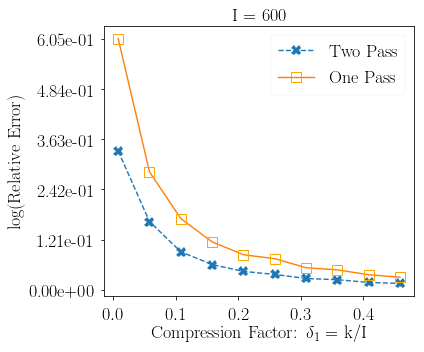

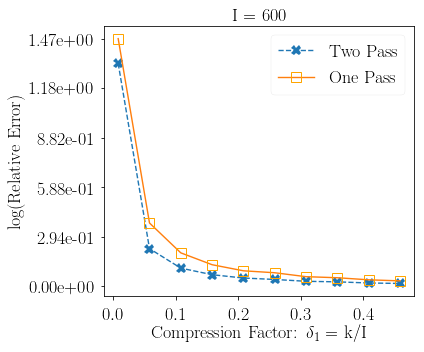

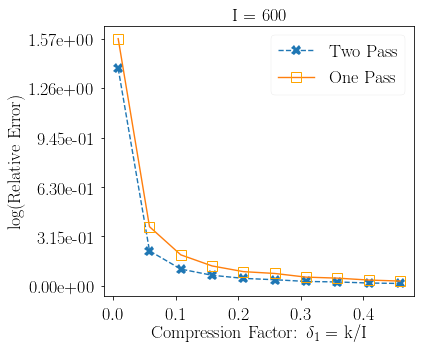

In [23]:
plot_nssimlog('id',5,1,"id_hnoise_n600log_paper.pdf",600)
plot_nssimlog('id',5,0.1,"id_mnoise_n600log_paper.pdf",600)
plot_nssimlog('id',5,0.01,"id_lnoise_n600log_paper.pdf",600)

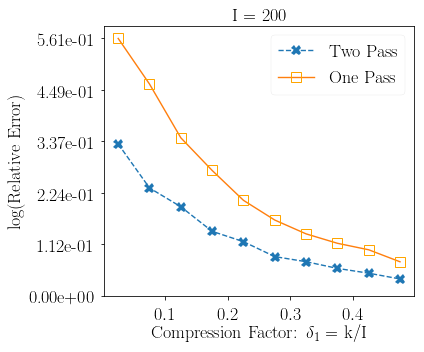

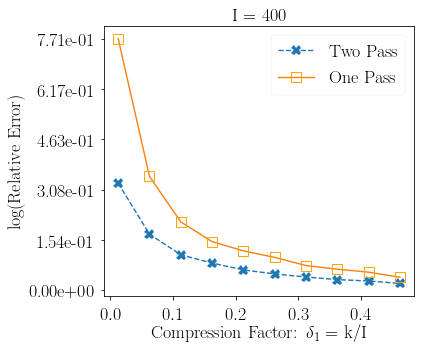

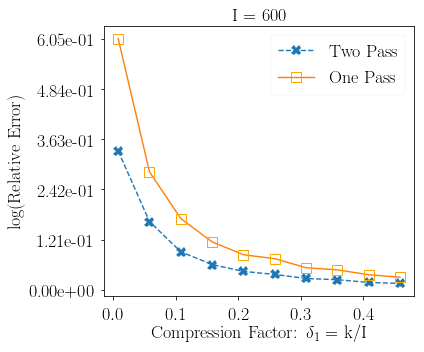

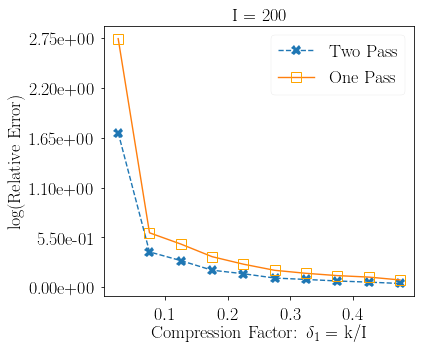

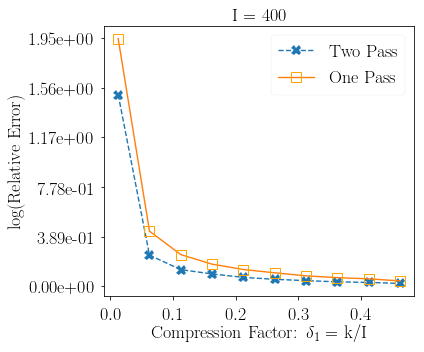

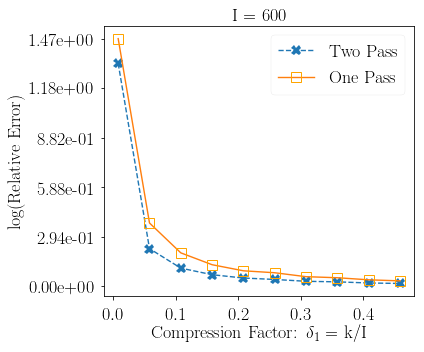

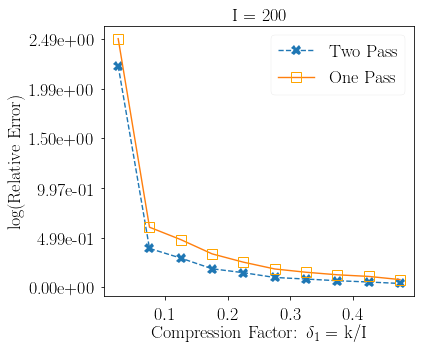

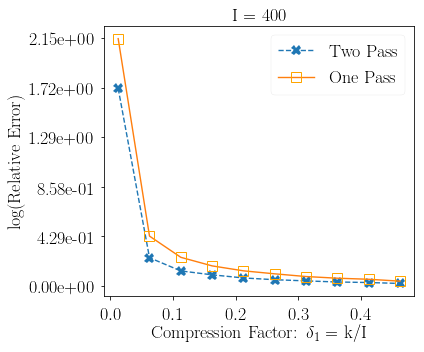

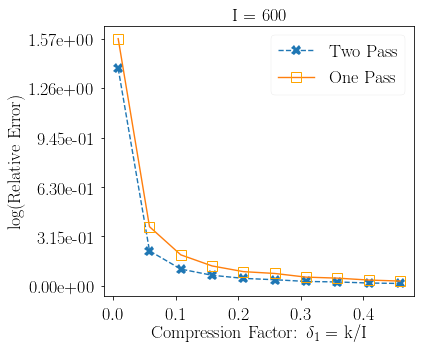

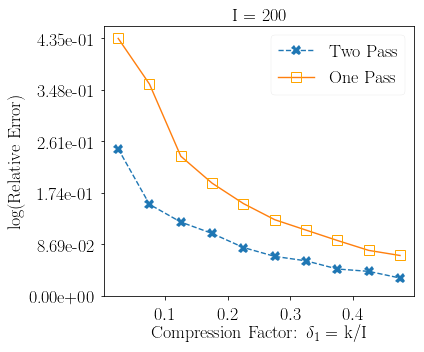

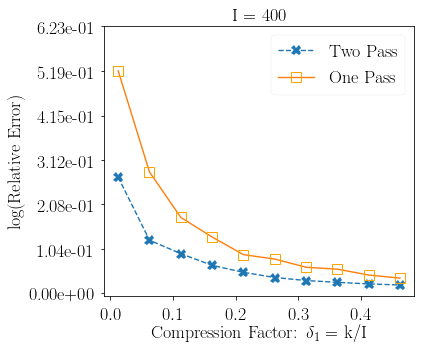

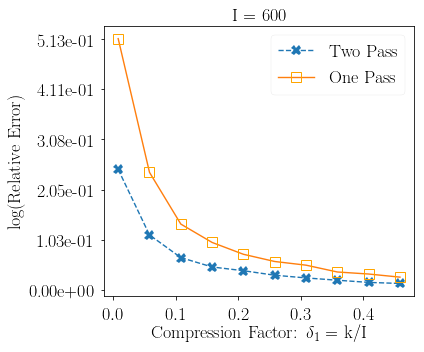

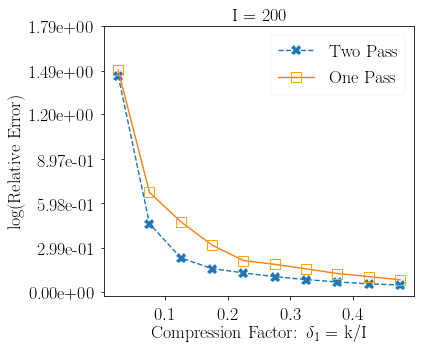

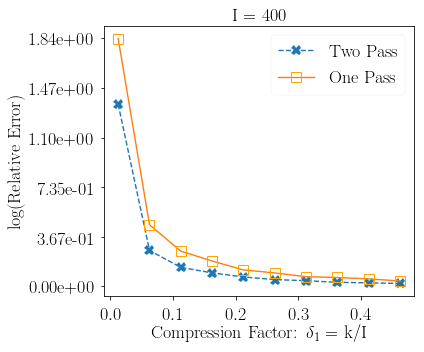

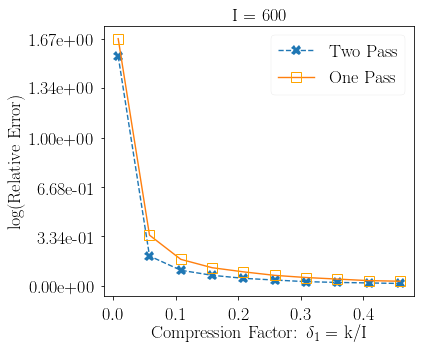

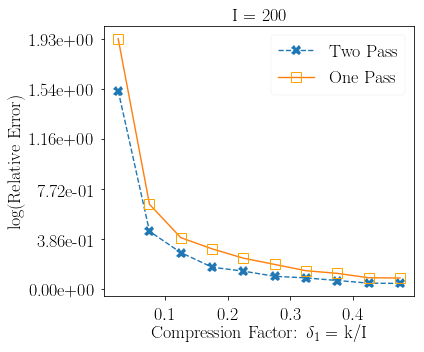

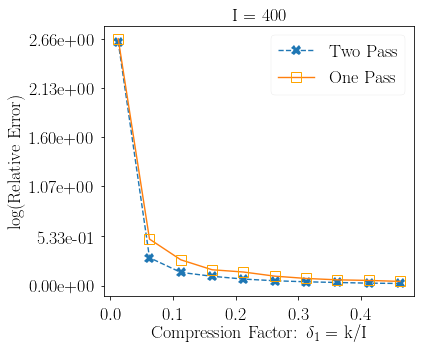

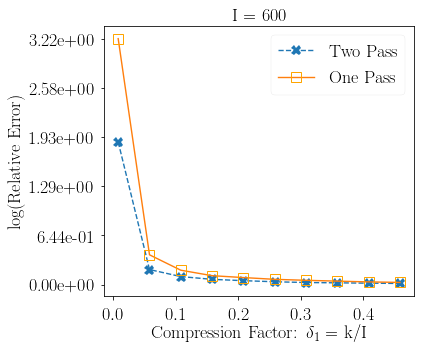

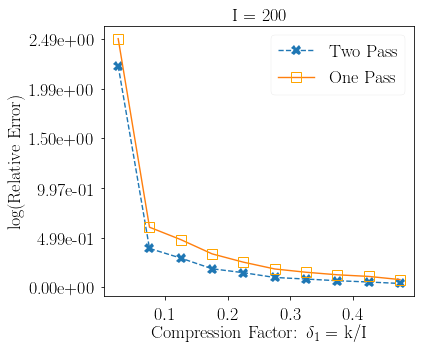

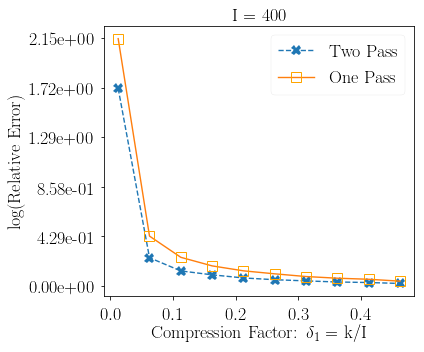

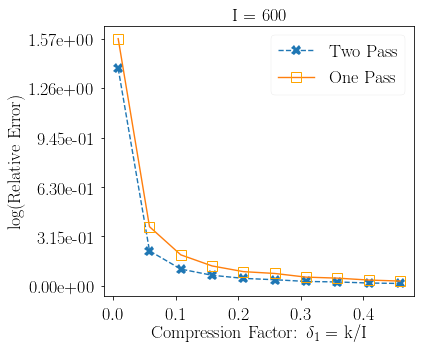

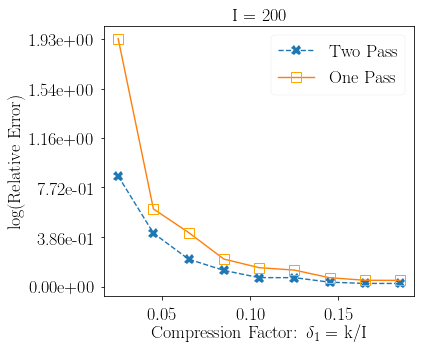

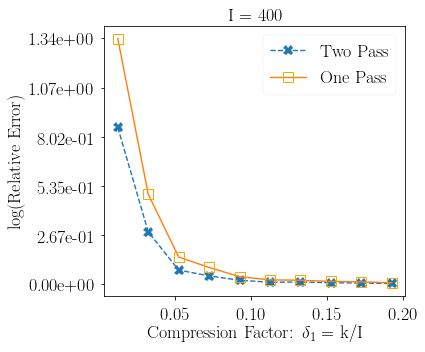

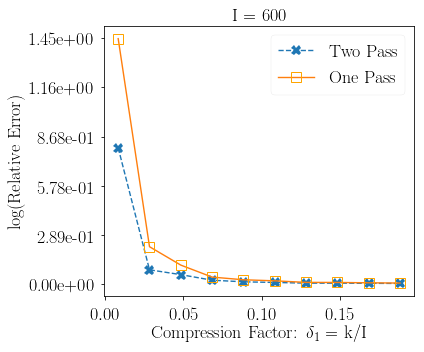

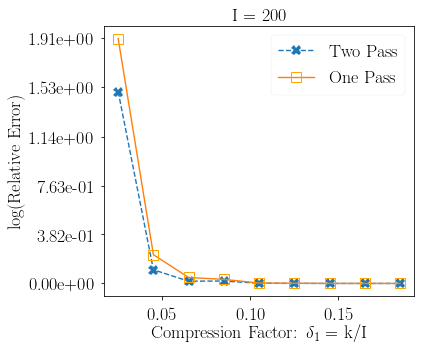

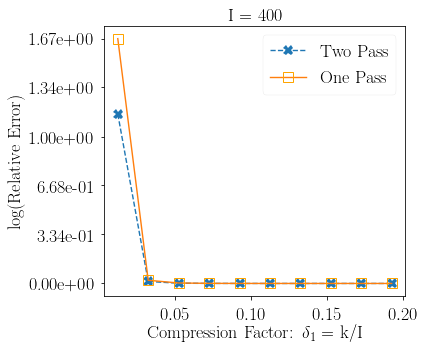

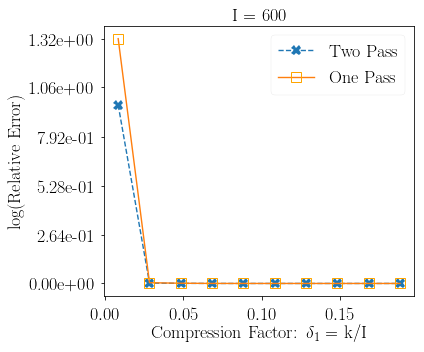

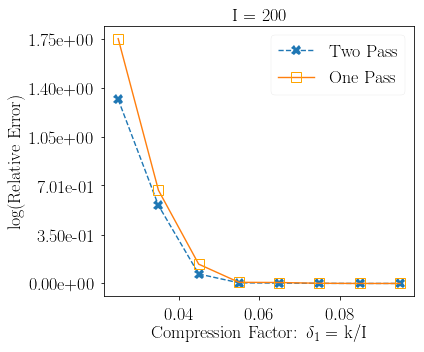

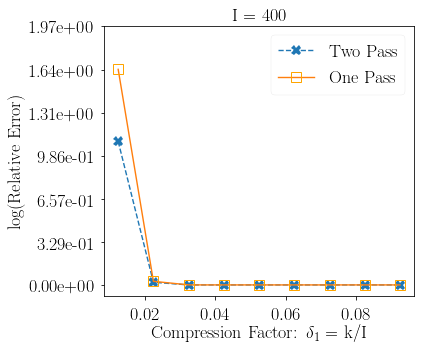

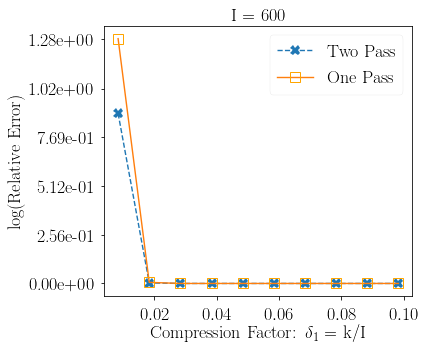

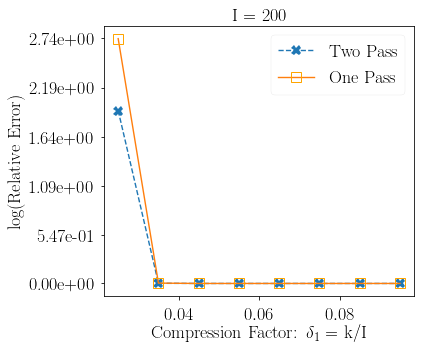

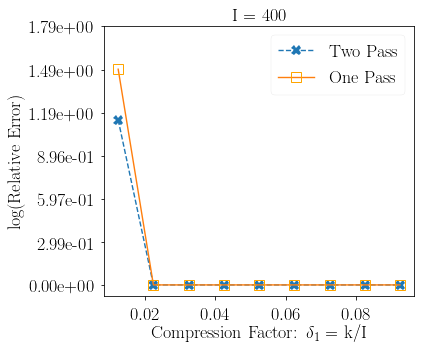

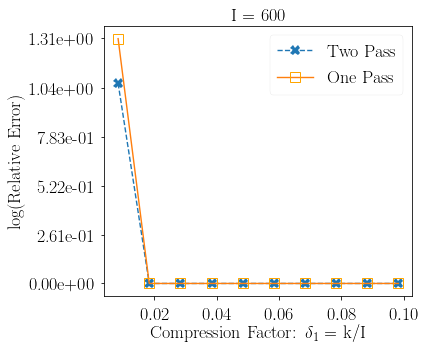

In [24]:
plot_nssimlog('id',5,1,"id_hnoise_n200log.pdf",200)
plot_nssimlog('id',5,1,"id_hnoise_n400log.pdf",400)
plot_nssimlog('id',5,1,"id_hnoise_n600log.pdf",600)
plot_nssimlog('id',5,0.1,"id_mnoise_n200log.pdf",200)
plot_nssimlog('id',5,0.1,"id_mnoise_n400log.pdf",400)
plot_nssimlog('id',5,0.1,"id_mnoise_n600log.pdf",600)
plot_nssimlog('id',5,0.01,"id_lnoise_n200log.pdf",200)
plot_nssimlog('id',5,0.01,"id_lnoise_n400log.pdf",400)
plot_nssimlog('id',5,0.01,"id_lnoise_n600log.pdf",600)
plot_nssimlog('lk',5,1,"lk_hnoise_n200log.pdf",200)
plot_nssimlog('lk',5,1,"lk_hnoise_n400log.pdf",400)
plot_nssimlog('lk',5,1,"lk_hnoise_n600log.pdf",600)
plot_nssimlog('lk',5,0.1,"lk_mnoise_n200log.pdf",200)
plot_nssimlog('lk',5,0.1,"lk_mnoise_n400log.pdf",400)
plot_nssimlog('lk',5,0.1,"lk_mnoise_n600log.pdf",600)
plot_nssimlog('lk',5,0.01,"lk_lnoise_n200log.pdf",200)
plot_nssimlog('lk',5,0.01,"lk_lnoise_n400log.pdf",400)
plot_nssimlog('lk',5,0.01,"lk_lnoise_n600log.pdf",600)
plot_nssimlog('id',5,0.01,"id_rk1_n200log.pdf",200)
plot_nssimlog('id',5,0.01,"id_rk1_n400log.pdf",400)
plot_nssimlog('id',5,0.01,"id_rk1_n600log.pdf",600)
plot_nssimlog('spd',5,0.01,"spd_n200log.pdf",200)
plot_nssimlog('spd',5,0.01,"spd_n400log.pdf",400)
plot_nssimlog('spd',5,0.01,"spd_n600log.pdf",600)
plot_nssimlog('fpd',5,0.01,"fpd_n200log.pdf",200)
plot_nssimlog('fpd',5,0.01,"fpd_n400log.pdf",400)
plot_nssimlog('fpd',5,0.01,"fpd_n600log.pdf",600)
plot_nssimlog('sed',5,0.01,"sed_n200log.pdf",200)
plot_nssimlog('sed',5,0.01,"sed_n400log.pdf",400)
plot_nssimlog('sed',5,0.01,"sed_n600log.pdf",600)
plot_nssimlog('fed',5,0.01,"fed_n200log.pdf",200)
plot_nssimlog('fed',5,0.01,"fed_n400log.pdf",400)
plot_nssimlog('fed',5,0.01,"fed_n600log.pdf",600)

In [ ]:
run_nssim('sed',5,0.01,np.arange(200,601,200)) 
run_nssim('fed',5,0.01,np.arange(200,601,200)) 
run_nssim('spd',5,0.01,np.arange(200,601,200)) 
run_nssim('fpd',5,0.01,np.arange(200,601,200)) 
run_nssim('id',5,0.01,np.arange(200,601,200)) 
run_nssim('id',5,0.1,np.arange(200,601,200)) 
run_nssim('id',5,1,np.arange(200,601,200)) 
run_nssim('id',1,0.01,np.arange(200,601,200)) 
run_nssim('lk',5,0.01,np.arange(200,601,200)) 
run_nssim('lk',5,0.1,np.arange(200,601,200)) 
run_nssim('lk',5,1,np.arange(200,601,200)) 

In [5]:
def run_nssim_fk(gen_type,r0,noise_level, n, dim = 3,random_seed = 1, rm_typ = "g"): 
    '''
    Simulate the dataset with fixed k and varying rank r, and perform HOOI, two-pass sketching, one-pass
    sketching for each setting. 
    '''
    X, X0 = tensorsketch.util.square_tensor_gen(n, r0, dim, typ=gen_type,\
         noise_level=noise_level, seed = random_seed)
    k = int(n*1/3)  
    s = 2*k+1
    rs = np.arange(int(r0/2),int(n/10),int(n/200))
    _, _, _, hooi_rerr, _ = tensorsketch.tensor_approx.TensorApprox(X, np.repeat(r0,dim),rm_typ = rm_typ).tensor_approx('hooi') 
    hooi_result = np.repeat(hooi_rerr, len(rs))
    two_pass_result = np.zeros(len(rs))
    one_pass_result = np.zeros(len(rs))
    for idx, r in enumerate(rs):   
        sim = tensorsketch.tensor_approx.TensorApprox(X, np.repeat(r,dim), np.repeat(k,dim), np.repeat(s,dim), rm_typ = rm_typ)
        _, _, _, two_pass_rerr, _ = sim.tensor_approx('twopass')
        _, _, _, one_pass_rerr, _ = sim.tensor_approx('onepass')
        one_pass_result[idx] = one_pass_rerr
        two_pass_result[idx] = two_pass_rerr
    sim_list = [two_pass_result,one_pass_result,hooi_result]
    pickle.dump( sim_list, open(sim_name(gen_type,r0,noise_level,dim) +"_n"+str(n)+"_"+rm_typ+"fk.pickle", "wb" ) )
    return sim_list

In [6]:
def plot_nssim_fk(gen_type,r0,noise_level, n, name, title, dim = 3,random_seed = 1,fontsize = 18): 
    sim_list = pickle.load(open(sim_name(gen_type,r0,noise_level,dim) +"_n"+str(n)+"fk.pickle","rb"))
    k = int(n*1/3)  
    s = 2*k+1
    rs = np.arange(int(r0/2),int(n/10),int(n/200))
    rratios = rs/n
    
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)    
    plt.figure(figsize=(6,5))
    two_pass_result = [np.log(sim_list[0][i]/sim_list[2][i]) for i in range(len(sim_list[2]))]
    one_pass_result = [np.log(sim_list[1][i]/sim_list[2][i]) for i in range(len(sim_list[2]))]
        
    plt.plot(rratios,two_pass_result, label = 'Two Pass', markersize = 10, linestyle = '--',marker = 'X')
    plt.plot(rratios,one_pass_result, label = 'One Pass', markersize = 10, marker = 's',markeredgewidth=1,markeredgecolor='orange', markerfacecolor='None') 
    plt.legend(loc = 'best')
    plt.title(title)
    plt.xlabel('Relative Rank: $rk/I$')
    plt.ylabel('log(Relative Error)')
    plt.minorticks_off()
    alldata = np.concatenate([one_pass_result,two_pass_result])
    ymin = min(alldata)
    ymax = max(alldata) 
    def round_to_n(x,n): 
        if x == 0: 
            return 0
        else: 
            return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
    plt.yticks(ticks)
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
    plt.axes().xaxis.set_major_locator(ticker.MaxNLocator(10))
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.axhline(0, color='black',linewidth = 1)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig("plots/"+name+".pdf")
    plt.show()

In [7]:
run_nssim_fk('lk',5,0.01,600)
run_nssim_fk('lk',5,0.1,600)
run_nssim_fk('lk',5,1,600)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[array([0.78347341, 0.72240403, 0.72239724, 0.72238843, 0.72237753,
        0.72236382, 0.72234803, 0.72232929, 0.72230693, 0.72228178,
        0.72225323, 0.72222018, 0.72218423, 0.72214375, 0.72209989,
        0.72205063, 0.72199647, 0.72193838, 0.72187474, 0.72180557]),
 array([0.78816953, 0.73791566, 0.73927102, 0.74097726, 0.74311361,
        0.74572131, 0.74860407, 0.75188451, 0.7555317 , 0.75946837,
        0.76362197, 0.76794573, 0.77244711, 0.77710775, 0.78189913,
        0.78684258, 0.79183825, 0.7969133 , 0.80201739, 0.80710302]),
 array([0.7070766, 0.7070766, 0.7070766, 0.7070766, 0.7070766, 0.7070766,
        0.7070766, 0.7070766, 0.7070766, 0.7070766, 0.7070766, 0.7070766,
        0.7070766, 0.7070766, 0.7070766, 0.7070766, 0.7070766, 0.7070766,
        0.7070766, 0.7070766])]

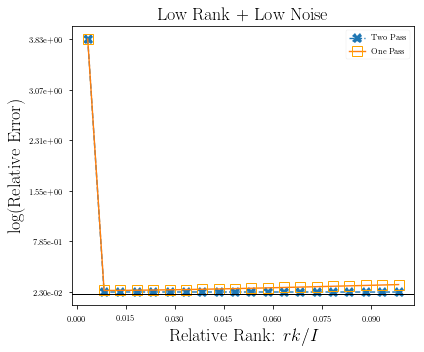

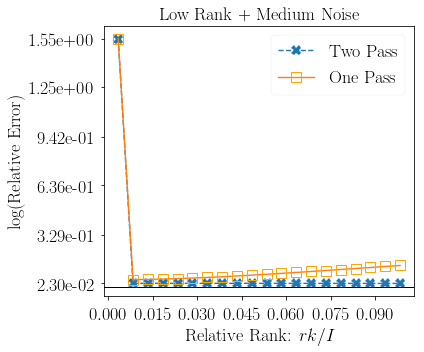

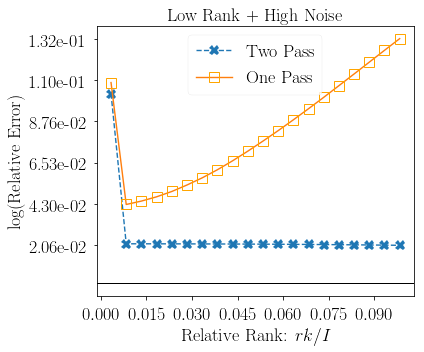

In [8]:
plot_nssim_fk('lk',5,0.01,600,'lk_lnoise_n600fk', "Low Rank + Low Noise")
plot_nssim_fk('lk',5,0.1,600,'lk_mnoise_n600fk', "Low Rank + Medium Noise")
plot_nssim_fk('lk',5,1,600,'lk_hnoise_n600fk', "Low Rank + High Noise ")

In [9]:
run_nssim_fk('spd',5,0.01,600)
run_nssim_fk('fpd',5,0.01,600)
run_nssim_fk('sed',5,0.01,600)

Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

[array([7.81899811e-01, 1.68577238e-01, 2.99777431e-02, 5.33088033e-03,
        9.47979473e-04, 1.68577238e-04, 2.99777431e-05, 5.33088033e-06,
        9.47979473e-07, 1.68577238e-07, 2.99824846e-08, 9.47981737e-09,
        1.68577234e-09, 2.99784994e-10, 9.47977413e-11, 1.68577241e-11,
        2.99777871e-12, 5.33110737e-13, 9.48692352e-14, 1.95102006e-14]),
 array([7.81899811e-01, 1.68577238e-01, 2.99777431e-02, 5.33088033e-03,
        9.47979473e-04, 1.68577238e-04, 2.99777431e-05, 5.33088033e-06,
        9.47979473e-07, 1.68577239e-07, 2.99794046e-08, 9.47979443e-09,
        1.68577229e-09, 2.99779114e-10, 9.47979345e-11, 1.68577284e-11,
        2.99778112e-12, 5.33148007e-13, 9.52659087e-14, 1.85094468e-14]),
 array([0.16857724, 0.16857724, 0.16857724, 0.16857724, 0.16857724,
        0.16857724, 0.16857724, 0.16857724, 0.16857724, 0.16857724,
        0.16857724, 0.16857724, 0.16857724, 0.16857724, 0.16857724,
        0.16857724, 0.16857724, 0.16857724, 0.16857724, 0.16857724])]

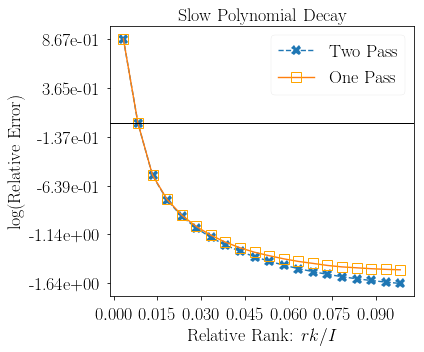

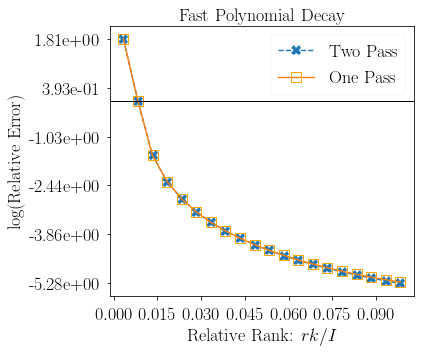

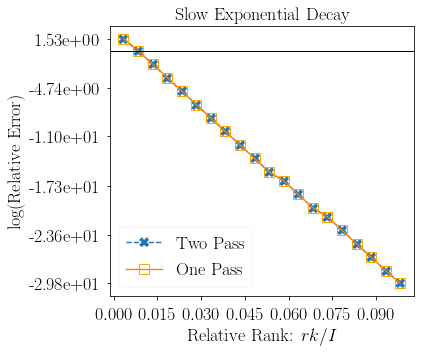

In [10]:
plot_nssim_fk('spd',5,0.01,600,'spd_n600fk','Slow Polynomial Decay')
plot_nssim_fk('fpd',5,0.01,600, 'fpd_n600fk','Fast Polynomial Decay')
plot_nssim_fk('sed',5,0.01,600, 'sed_n600fk','Slow Exponential Decay')